In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

In [3]:
# Constants
RENDER = True
TIMESTEPS = 30000
REPLAY_BUFFER_SIZE = 100000
LEARNING_START = 10000
BATCH_SIZE = 256
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.001

In [4]:
from displayframesasgif import display_frames_as_gif
from replaybuffer import ReplayBuffer, PrioritizedReplayBuffer
from ddpg import DDPG
from amc import AMC
from deepmlac import DeepMLAC
from neuralnetwork import NeuralNetwork
from layers import *
from movingaverage import MovingAverage

In [5]:
env = gym.make('Pendulum-v0') #Pendulum-v0, MountainCarContinuous-v0

[2017-04-01 21:23:00,868] Making new env: Pendulum-v0


In [6]:
observation = env.reset()
frames = []
reward_avg = MovingAverage(100)
total_rewards = [0]

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [7]:
print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
actor_network = NeuralNetwork("Actor", session, [state_dim])
a_h0 = FullyConnectedLayer("h0", 256, actor_network.get_input_layer(0), tf.nn.relu)
a_h1 = FullyConnectedLayer("h1", 128, a_h0, tf.nn.relu)
a_out = FullyConnectedLayer("out", action_dim, a_h1, tf.identity)
a_bounded = BoundingLayer("bounded", a_out, env.action_space.low, env.action_space.high)
actor_network.compile(a_bounded)

print(str(actor_network))

q_network = NeuralNetwork("Q", session, [state_dim, action_dim])
q_concat = ConcatLayer("concat", [q_network.get_input_layer(0), q_network.get_input_layer(1)])
#q_bn0 = BatchNormalizationLayer("bn0", q_concat)
q_h0 = FullyConnectedLayer("h0", 256, q_concat, tf.nn.relu)
q_h1 = FullyConnectedLayer("h1", 128, q_h0, tf.nn.relu)
q_out = FullyConnectedLayer("out", 1, q_h1, tf.identity)
q_network.compile(q_out)

model_network = NeuralNetwork("Model", session, [state_dim, action_dim])
m_concat = ConcatLayer("concat", [model_network.get_input_layer(0), model_network.get_input_layer(1)])
m_h0 = FullyConnectedLayer("h0", 256, m_concat, tf.nn.relu)
m_h1 = FullyConnectedLayer("h1", 128, m_h0, tf.nn.relu)
m_out = FullyConnectedLayer("out", state_dim, m_h1, tf.identity)
model_network.compile(m_out)

reward_network = NeuralNetwork("Reward", session, [state_dim, action_dim])
r_concat = ConcatLayer("concat", [reward_network.get_input_layer(0), reward_network.get_input_layer(1)])
r_h0 = FullyConnectedLayer("h0", 256, r_concat, tf.nn.relu)
r_h1 = FullyConnectedLayer("h1", 128, r_h0, tf.nn.relu)
r_out = FullyConnectedLayer("out", 1, r_h1, tf.identity)
reward_network.compile(r_out)

value_network = NeuralNetwork("Value", session, [state_dim])
v_h0 = FullyConnectedLayer("h0", 256, value_network.get_input_layer(0), tf.nn.relu)
v_h1 = FullyConnectedLayer("h1", 128, v_h0, tf.nn.relu)
v_out = FullyConnectedLayer("out", 1, v_h1, tf.identity)
value_network.compile(v_out)

agent = DDPG(actor_network, q_network, discount_factor=DISCOUNT_FACTOR, tf_optimizer=tf.train.AdamOptimizer(0.0001))
#agent = AMC(actor_network, model_network, reward_network, value_network, forward_steps=1, discount_factor=DISCOUNT_FACTOR, tf_optimizer=tf.train.AdamOptimizer(0.0001))
#agent = DeepMLAC(actor_network, model_network, reward_network, value_network, forward_steps=5, discount_factor=DISCOUNT_FACTOR, trace_decay=0.5, tf_optimizer=tf.train.AdamOptimizer(0.0001))

[] --> Actor_input_0
['Actor_input_0'] --> h0
['h0'] --> h1
['h1'] --> out
['out'] --> bounded



In [10]:
tvars = tf.trainable_variables()
tvars_vals = session.run(tvars)

#for var, val in zip(tvars, tvars_vals):
#    print(var.name, val)

In [11]:
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE, state_dim, action_dim)

In [12]:
state = np.array(env.reset())

# model pretraining
'''for t in range(20000):
    action = env.action_space.sample()
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(observation, (state_dim,))
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    
    agent.train_model()
    
agent.reset_replay_buffer()'''

'for t in range(20000):\n    action = env.action_space.sample()\n    \n    observation, reward, done, info = env.step(action)\n    next_state = np.reshape(observation, (state_dim,))\n    replay_buffer.add(state, action, reward, next_state, done)\n    state = next_state\n    \n    agent.train_model()\n    \nagent.reset_replay_buffer()'

In [13]:
progress_bar = tqdm(total=TIMESTEPS)
episode_reward = 0
episote_duration = 0

for t in xrange(TIMESTEPS):   
    action = None
    
    exploration_probability = ((TIMESTEPS - t) / float(TIMESTEPS)) ** 2
    if t < LEARNING_START:
        exploration_probability = 1
    
    if random.uniform(0, 1) < exploration_probability:
        action = env.action_space.sample()
    else:
        action = agent.action(state)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(observation, (state_dim,))
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    
    episode_reward += reward
    episote_duration += 1
    total_rewards.append(total_rewards[-1] + reward)
    
    if done:
        state = np.array(env.reset())
        print("Episode over. Total reward: {}. Solved in {} steps.".format(episode_reward, episote_duration))
        episode_reward = 0
        episote_duration = 0
        
    if t >= LEARNING_START:
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.get_batch(BATCH_SIZE)
        agent.train(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        if RENDER and t % 60 == 0:
            frames.append(env.render(mode = 'rgb_array'))
    #else:
        #agent.train(train_actor=False, train_model=True, train_reward=True, train_value=False)
            
    reward_avg.add_value(reward)    
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration proba: {:.2f}, action: {}' \
        .format(t, reward, reward_avg.get_average(), exploration_probability, str(action)))
    progress_bar.update()
    
        
progress_bar.close()

[29999] reward: -0.00, reward 100-step MA: -0.00, Exploration proba: 0.00, action: [ 0.07454613]: 100%|██████████| 30000/30000 [02:08<00:00, 232.82it/s] 349/30000 [00:00<00:08, 3485.99it/s]


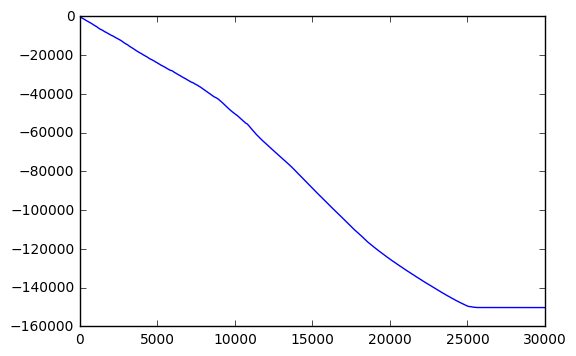

In [14]:
plt.plot(total_rewards)

In [15]:
#if RENDER:
#    display_frames_as_gif(frames)

In [16]:
cache = [1, None, None, 1, None, 1, 1]
[i for i, v in enumerate(cache) if v is not None]

[0, 3, 5, 6]